In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import tensorflow as tf
import time
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def fetchFlows(startDate, endDate):
    res = requests.get("https://api-wait-times/api/flows/SHGJLYDJQ/count?startDate=" + startDate + "&endDate=" + endDate)
    result = res.json()
    return result

def fetchTickets(startDate, endDate):
    res = requests.get("http://club17-ticket-service/api/report/tickets/count?startDate=" + startDate + "&endDate=" + endDate)
    res = res.json()

    dayNum = 0
    for item in res:
        if dayNum > 0:
            beforeItem = res[dayNum - 1]
            item['beforePrice'] = beforeItem['price']
        dayNum = dayNum + 1

    return res


In [5]:
startDate = '2021-03-10'
endDate = '2021-06-30'

df = fetchFlows(startDate, endDate)
df_flows = pd.json_normalize(df)
df_flows = df_flows[['max', 'avg']]

# df_ticket = fetchTickets(startDate, endDate)
# df_ticket = pd.json_normalize(df_ticket)


# df = pd.concat([df_ticket, df_flows.reindex(df_ticket.index)], axis=1)

df

In [2]:
# df['isWeekend'] = df['isWeekend']*1.0
df['memberDay'] = df['date'].map(lambda x: 1 if datetime.strptime(x,"%Y-%m-%d").weekday() == 6 else 0)
df['memberDay'] = df['memberDay']*10000

df['flows'] = df['max']
df['tickets'] = df['total']
dataset = df[['tickets', 'flows', 'price', 'memberDay', 'beforePrice']]
dataset = dataset[1:]
dataset

NameError: name 'df' is not defined

In [94]:
# 拆分训练数据集和测试数据集

train_dataset = dataset.sample(frac=0.7,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
# test_dataset = train_dataset
dataset.drop(train_dataset.index)
# test_dataset

,tickets,flows,price,memberDay,beforePrice
1,375,17318,399,0,399.0
4,1415,62622,399,10000,399.0
12,1201,35422,399,0,399.0
13,1196,33816,399,0,399.0
16,4686,42608,399,0,399.0
17,1271,32808,599,0,399.0


In [95]:
train_stats = train_dataset.describe()
train_stats.pop("flows")
train_stats = train_stats.transpose()

train_stats

,count,mean,std,min,25%,50%,75%,max
tickets,14.0,1031.428571,488.141643,370.0,699.75,1040.5,1285.75,2181.0
price,14.0,413.285714,53.452248,399.0,399.00,399.0,399.00,599.0
memberDay,14.0,1428.571429,3631.365196,0.0,0.00,0.0,0.00,10000.0
beforePrice,14.0,427.571429,72.627304,399.0,399.00,399.0,399.00,599.0


In [96]:
# 从标签中分离特征
train_labels = train_dataset.pop('flows')
test_labels = test_dataset.pop('flows')

In [97]:
# 数据规范化

# def norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)

normed_train_data = train_dataset
normed_test_data = test_dataset

In [98]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [99]:
model = build_model()
model.summary()

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


array([[-214.37354],
       [-166.8934 ],
       [-144.5098 ],
       [-140.42041],
       [-720.94824],
       [-744.49347],
       [-115.46698],
       [-178.1329 ],
       [-151.57072],
       [-258.84744]], dtype=float32)

In [100]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [101]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,3434581.75,1277.119995,3434581.75,3473748.00,1628.941406,3473748.00,495
496,3434156.25,1230.291382,3434156.25,5134841.00,2036.830688,5134841.00,496
497,3430816.00,1275.593872,3430816.00,3484339.75,1631.361938,3484339.75,497
498,3430700.25,1229.351440,3430700.25,5136375.50,2036.763062,5136375.50,498
499,3427929.50,1274.989014,3427929.50,3489148.75,1632.189453,3489148.75,499


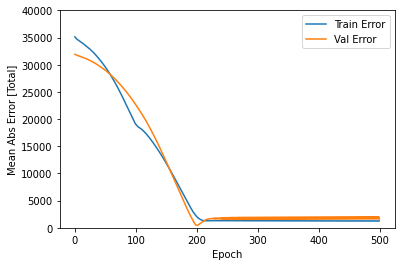

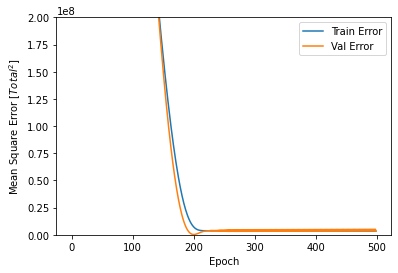

In [102]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Total]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,40000])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Total^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,200000000])
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
.............................................................................................

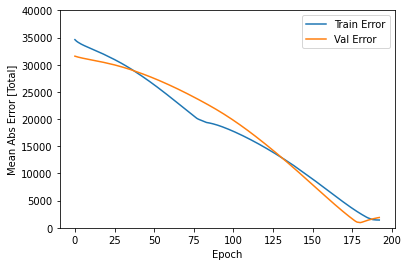

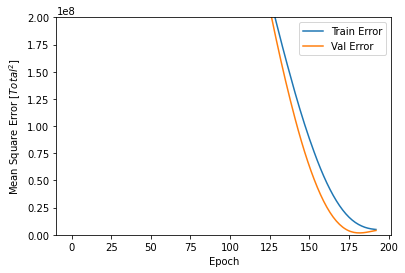

In [103]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................

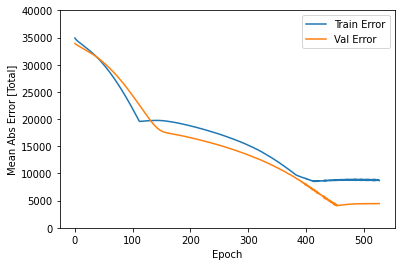

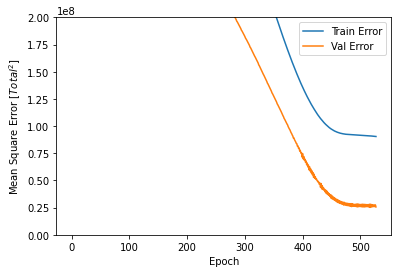

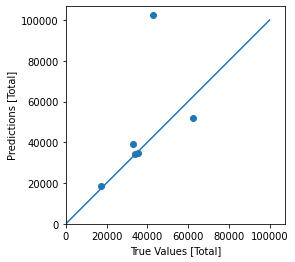

In [106]:
# 做预测
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Total]')
plt.ylabel('Predictions [Total]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100000, 100000], [-100000, 100000])

In [105]:
model.save('../model/flows.h5')

normed_test_data

,tickets,price,memberDay,beforePrice
1,375,399,0,399.0
4,1415,399,10000,399.0
12,1201,399,0,399.0
13,1196,399,0,399.0
16,4686,399,0,399.0
17,1271,599,0,399.0
